# Play Shakespeare in Python

* 数据: 莎士比亚作品 [xml格式](https://github.com/severdia/PlayShakespeare.com-XML) (感谢severdia分享)
    * 此xml数据比较规整, 且有不少除剧本台词之外的信息, 例如 meta data 有关题材分类Genre等
* 处理 xml 文件转化为 DataFrame
* 从人物台词推测出自悲剧/喜剧/历史剧
    * `MultinomialNB`
    * linear SVM: `SGDClassifier`
    * 尝试 stemming tokenizer
    * `grid search`确定合适参数
* 假设不知道 genre, 尝试聚类
    * `KMeans`
    * `MiniBatchKMeans`
* 可视化
    * Term Document Matrix
    * word cloud

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster

## 处理 xml 文件 转化为 dataframe

* 使用 lxml/xml 等工具解析
* 探索过程详见 `how-to-convert-xml-to-pandas-dataframe.ipynb`

In [3]:
# -*- coding: utf-8 -*-
'''
convert shakespeare xml to dataframe
@author: bambooom
'''

from lxml import objectify
import xml.etree.ElementTree as etree
import lxml.etree
import pandas as pd
import numpy as np
import os

def xml2df():
    file_list = []
    # walk down into folder to get the list of all xml files
    for dirpath, dirs, files in os.walk('text_Data_xml'):
        file_list.append(files)

    file_list = np.ravel(file_list) # flatten

    speeches = []
    plays_name = []
    genre_list = []
    speakers = []

    # for each xml file
    for file_name in file_list:
        path = 'text_data_xml/%s'% file_name
        tree = etree.parse(path)
        root = tree.getroot()
        xml = objectify.parse(open(path))
        root_xml = xml.getroot()

        for e in root_xml.getchildren():
            if e.tag == 'act':
                for ee in e.getchildren():
                    if ee.tag == 'scene':
                        for eee in ee.getchildren():
                            if eee.tag == 'speech': # find speech element to extract all lines
                                name = unicode(root_xml.getchildren()[0].text.encode('utf-8'), "utf-8")
                                gen = root.attrib['genre']

                                speakers.append(str(eee.getchildren()[0]))
                                plays_name.append(name)
                                genre_list.append(gen)
                                for i in eee.getchildren()[1:]:
                                    if i.text is not None:
                                        lines = ''.join(unicode(i.text.encode('utf-8'),'utf-8'))
                                    else:
                                        continue
                                speeches.append(lines)

    d = {'speeches':speeches, 'plays_name':plays_name,
        'genre':genre_list, 'speakers':speakers}
    speech_all = pd.DataFrame(d)

    return speech_all

In [4]:
speech_all = xml2df()

**Note:** 有关 xml 转为 dataframe, 中间遇到两个问题:
* 一个是对`lxml/xml`运用不熟练, 现在的做法只是循环套循环, 比较繁琐, 是否有更简单的方法呢? 
* 二就是有关编码问题.....英文都有, 如果要运用到中文上, 更有可能存在问题.

另外, 莎翁作品一般分为的是四类, 但`诗/poem`格式较特殊, 与其他三种不一样, 以上转化暂时将`诗/poem`去掉.

In [5]:
speech_all.info() #没有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33447 entries, 0 to 33446
Data columns (total 4 columns):
genre         33447 non-null object
plays_name    33447 non-null object
speakers      33447 non-null object
speeches      33447 non-null object
dtypes: object(4)
memory usage: 1.3+ MB


## 台词推测悲剧/喜剧/历史剧

参考:
* [Building a Genre Classifier for Shakespeare Speeches](http://www.adampalay.com/notebooks/shakespeare-genre-classifier.html)
* [Text Mining the Complete Works of William Shakespeare](http://www.r-bloggers.com/text-mining-the-complete-works-of-william-shakespeare/)

参考 `sklearn` 中如何处理文本数据
* http://scikit-learn.org/stable/modules/feature_extraction.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

另外需要处理文本数据的话, 可以用到 `nltk` 这个包, 参考
* [nltk 官网](http://www.nltk.org/)
* [Natural Language Processing with Python](http://www.nltk.org/book/)
* [demo](http://text-processing.com/demo/)

In [6]:
speech_all.head()

,genre,plays_name,speakers,speeches
0,comedy,All’s Well That Ends Well,COUNT.,"In delivering my son from me, I bury a second ..."
1,comedy,All’s Well That Ends Well,BER.,"And I in going, madam, weep o’er my father’s d..."
2,comedy,All’s Well That Ends Well,LAF.,"You shall find of the King a husband, madam; y..."
3,comedy,All’s Well That Ends Well,COUNT.,What hope is there of his Majesty’s amendment?
4,comedy,All’s Well That Ends Well,LAF.,"He hath abandon’d his physicians, madam, under..."


In [7]:
# classification 仅用到 genre 和 speeches 两列数据
X_all = speech_all.speeches
Y_all = speech_all.genre

In [8]:
# split train, test, 80% 为 train, 20% 留存为 test
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X_all, Y_all, train_size=0.8)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
# 计算词频
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
X_train_counts.shape
# 26757 行数为总共多少句台词, 也就是 document 数量, 13321列数为分词后总共有这么多个单词

(26757, 13321)

In [11]:
# 一个巨大的 matrix
# 可以用 vocabulary_ 查看分词后的单词的 index
count_vec.vocabulary_.get(u'love')

6928

In [12]:
# 用 TfidfTransformer 转化词频数为 TF-IDF matrix
# term frequency * inverse document frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(26757, 13321)

In [13]:
# 使用 multinomial variant in naive bayes 进行分类
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [15]:
# 对 test data 处理为 tfidf, 进行 predict
X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(6690, 13321)

In [16]:
Y_predicted = clf.predict(X_test_tfidf)

In [17]:
np.mean(Y_predicted == Y_test)

0.53811659192825112

In [18]:
# MultinomialNB准确率不是太高, 换linear SVM, 被认为是 best text classification algorithm
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(X_train_tfidf, Y_train)

In [21]:
Y_predicted_svm = sgd.predict(X_test_tfidf)

In [22]:
np.mean(Y_predicted_svm == Y_test)

0.56292974588938716

linear SVM 比 MultinomialNB 准确率略有提升.

### 尝试使用 sterming tokenizer

和 nltk 配套使用

In [23]:
# stemming 是指只留主干部分, 去掉枝叶
# 参考Adam 做法
import nltk
from nltk.stem import PorterStemmer
import string

stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    # strip out punctuation and make lowercase
    tokens = [token.lower().strip(string.punctuation)
              for token in tokens if token.isalnum()]

    # now stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [24]:
# 加上 tokenizer 的词频
count_vec_token = CountVectorizer(tokenizer = tokenize_and_stem)

In [37]:
# note: 'tokenizers/punkt/english.pickle' tokenizer会需要用到 nltk 的这个 data, 需要提前下载
# http://stackoverflow.com/questions/26570944/resource-utokenizers-punkt-english-pickle-not-found
# 再次使用 MultinomialNB
X_train_tokenized = count_vec_token.fit_transform(X_train)

mnb = MultinomialNB()
mnb = mnb.fit(X_train_tokenized, Y_train)

In [39]:
X_test_tokenized = count_vec_token.transform(X_test)
Y_predicted_mnb = mnb.predict(X_test_tokenized)

In [40]:
np.mean(Y_predicted_mnb == Y_test)

0.55052316890881914

使用 tokenizer 之后的 MultinomialNB 比没有使用之前的准确率略有提升

### Grid search 确定合适参数

In [27]:
# grid search to determine parameters

from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-1, 1e-3),}

In [28]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),])

In [29]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [30]:
gs_clf = gs_clf.fit(X_train[:10000],Y_train[:10000])

In [31]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])

In [32]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [33]:
Y_predicted_gs = gs_clf.predict(X_test)

In [34]:
np.mean(Y_predicted_gs==Y_test)

0.51644245142002987

额 grid search 后分类效果反而变差.....why?

## 假设不知道 genre 进行聚类

In [35]:
# cluster 主要使用 Kmeans 和 minibatch Kmeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans

In [47]:
# min_df = 0.001 说明去掉 document freq 小于0.001的词
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df=0.001, stop_words='english',
                                 use_idf=True, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf.shape
# 余下 doc freq 高于0.001的词, 有763个

(26757, 763)

In [48]:
from sklearn.preprocessing import Normalizer

# 使用 truncated SVD 降维
# 常用于 Latent Semantic Analysis 潜在语义分析

svd = TruncatedSVD(100) # desired dimensionality, for LSA, 100 better
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [49]:
X_train_tfidf = lsa.fit_transform(X_train_tfidf)
svd.explained_variance_ratio_.sum() # explained variance of SVD step

0.42536508086505809

In [50]:
X_train_tfidf.shape # 在 svd 之后就只有100个了

(26757, 100)

### 用 KMeans

In [57]:
true_k = 3 # 实际有3种分类
km = KMeans(n_clusters = true_k, init='k-means++', n_init=1, max_iter=50000)

km.fit(X_train_tfidf)

KMeans(copy_x=True, init='k-means++', max_iter=50000, n_clusters=3, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [58]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, km.labels_, sample_size=1000))


Homogeneity: 0.003
Completeness: 0.015
V-measure: 0.005
Adjusted Rand-Index: 0.004
Silhouette Coefficient: 0.076


聚类结果并不好.  
Homogeneity, Completeness, V-measure, Adjusted Rand-Index 的结果越接近于1则表示 cluster 效果好.  
而 Silhouette Coefficient 接近于0 表示有重合 overlapping cluster

### 尝试 minibatch KMeans

In [59]:
# 尝试 minibatch kmeans

minikm = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, max_iter=50000)
minikm.fit(X_train_tfidf)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=50000, max_no_improvement=10,
        n_clusters=3, n_init=1, random_state=None, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [60]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, minikm.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, minikm.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, minikm.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, minikm.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, minikm.labels_, sample_size=1000))


Homogeneity: 0.000
Completeness: 0.001
V-measure: 0.000
Adjusted Rand-Index: 0.000
Silhouette Coefficient: 0.055


和 K means 情况类似, cluster 效果不好.

## Visualization

### Term Document Matrix Visualization

In [71]:
# 前面是对每一句台词都分开来做分类和聚类
# 可视化考虑将一部戏作为一个整体

grouped = speech_all.groupby('plays_name')

plays_title = []
plays_text = []
for name, group in grouped:
    plays_title.append(name)
    plays_text.append(' '.join(list(group.speeches)))

d = {'plays_title':plays_title, 'plays_text':plays_text}
plays_all = pd.DataFrame(d)
plays_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 2 columns):
plays_text     41 non-null object
plays_title    41 non-null object
dtypes: object(2)
memory usage: 984.0+ bytes


In [72]:
plays_all.head(2)

,plays_text,plays_title
0,Long withering out a young man’s revenue. Of o...,A Midsummer Night’s Dream
1,"In delivering my son from me, I bury a second ...",All’s Well That Ends Well


In [109]:
# 选取了一下 document freq 在0.5-0.6区间的词
count_vector = CountVectorizer(min_df = 0.5, max_df = 0.55)
term_count = count_vector.fit_transform(plays_all.plays_text)
term_count.shape

(41, 88)

In [110]:
# list vocabulary
count_vector.get_feature_names()

[u'above',
 u'ah',
 u'among',
 u'angry',
 u'approach',
 u'beard',
 u'beg',
 u'behold',
 u'blessing',
 u'bold',
 u'book',
 u'boys',
 u'calls',
 u'chamber',
 u'chance',
 u'color',
 u'conscience',
 u'course',
 u'cousin',
 u'dangerous',
 u'deed',
 u'deep',
 u'died',
 u'dinner',
 u'em',
 u'fashion',
 u'feast',
 u'fellows',
 u'field',
 u'forbid',
 u'general',
 u'hair',
 u'hate',
 u'hearing',
 u'heir',
 u'hell',
 u'hit',
 u'honorable',
 u'hurt',
 u'issue',
 u'least',
 u'lips',
 u'meaning',
 u'mighty',
 u'mock',
 u'mov',
 u'move',
 u'noise',
 u'oath',
 u'ourselves',
 u'owe',
 u'perceive',
 u'poison',
 u'praise',
 u'prayers',
 u'presence',
 u'proceed',
 u'proud',
 u'quarrel',
 u'respect',
 u'scarce',
 u'seal',
 u'second',
 u'self',
 u'servant',
 u'shake',
 u'silence',
 u'simple',
 u'sin',
 u'sister',
 u'small',
 u'soft',
 u'tale',
 u'teach',
 u'thoughts',
 u'title',
 u'town',
 u'traitor',
 u'undone',
 u'valiant',
 u'valor',
 u'virtuous',
 u'wert',
 u'wherein',
 u'whether',
 u'won',
 u'worship',

In [111]:
term_count.toarray().T

array([[0, 1, 0, ..., 1, 2, 2],
       [2, 0, 1, ..., 0, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [0, 2, 1, ..., 0, 1, 0],
       [1, 1, 3, ..., 0, 4, 0],
       [3, 0, 0, ..., 1, 2, 0]])

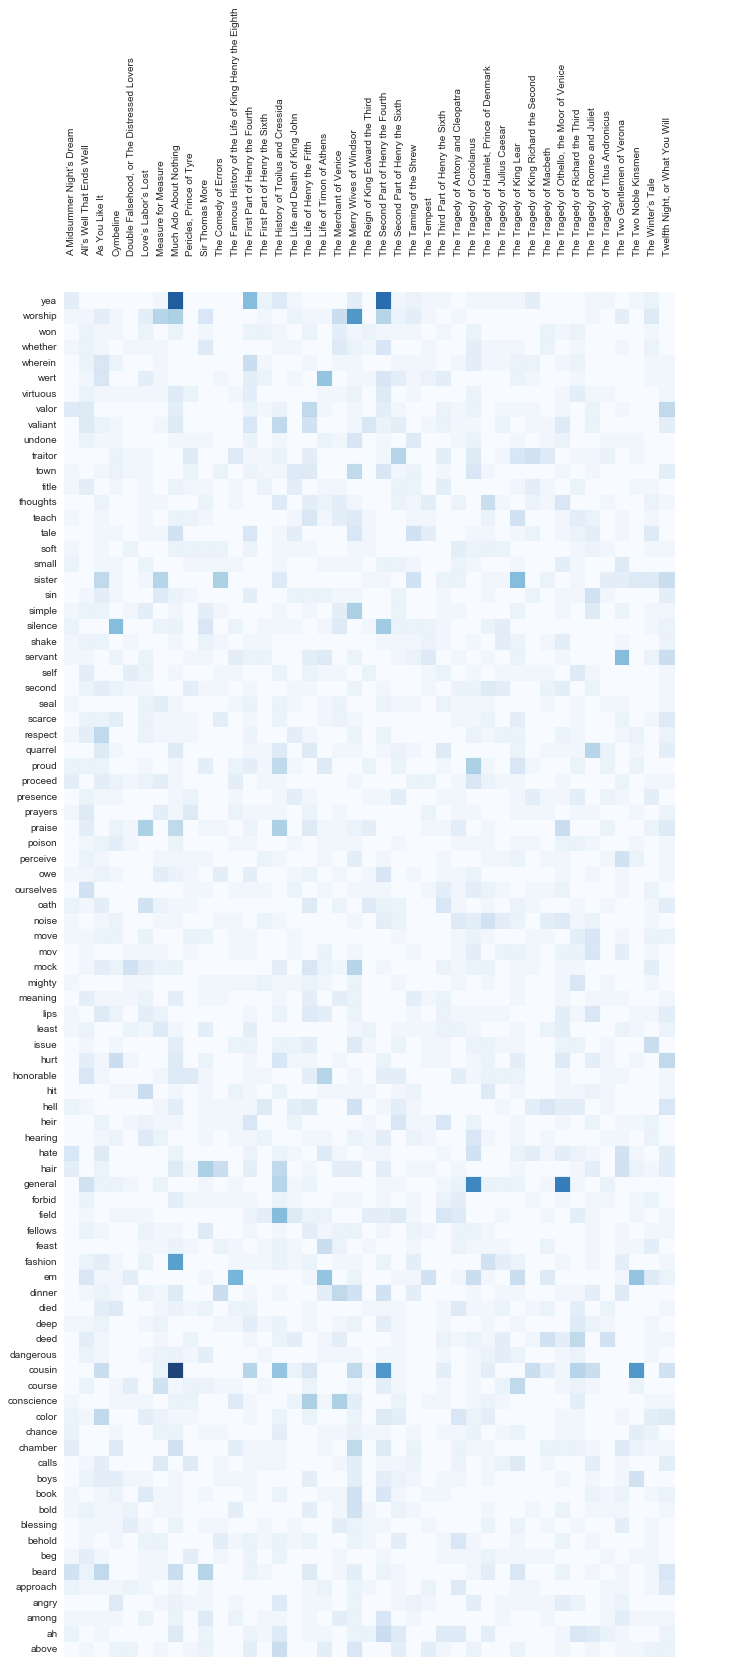

In [113]:
# 参考 http://nbviewer.jupyter.org/gist/joelotz/5427209
fig, ax = plt.subplots(figsize=(12,25))
heatmap = ax.pcolor(term_count.toarray().T, cmap=plt.cm.Blues, alpha=0.9)

ax.set_frame_on(False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(term_count.toarray().T.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(term_count.toarray().T.shape[1]) + 0.5, minor=False)

# add label
xlabel = plays_title #list of title
ylabel = count_vector.get_feature_names()
ax.set_xticklabels(xlabel, minor=False)
ax.set_yticklabels(ylabel, minor=False)

# rotate the x label
plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

### Word Cloud

需要安装 `wordcloud` 包

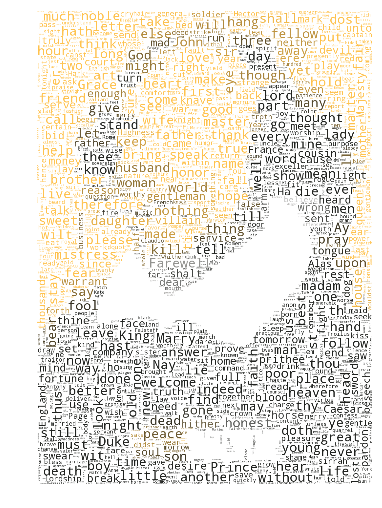

In [116]:
# -*- coding: utf-8 -*-
'''
word cloud generate for shakespeare
@author: bambooom
'''

from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#d = path.dirname(__file__)
# Read the whole text.
#text = open(path.join(d, 'text.txt')).read()
plays_full_text = ' '.join(plays_text)
# read the mask / color image
# taken from http://lukaskaraba.deviantart.com/art/Shakespeare-minimalist-poster-2-462903294
shakespeare_coloring = imread("mask.jpg")

wc = WordCloud(background_color="white", max_words=2000, mask=shakespeare_coloring,
               stopwords=STOPWORDS.add("said"),
               max_font_size=40, random_state=42)
# generate word cloud
wc.generate(plays_full_text)

image_colors = ImageColorGenerator(shakespeare_coloring)

plt.figure(figsize = (6,10))
plt.imshow(wc.recolor(color_func=image_colors),aspect='equal')
plt.axis("off")

plt.show()